# Generate Heatmap for keratinocytes

In [36]:
import sys
import subprocess

%matplotlib inline
import re
import glob
import os
import sys

import scanpy as sc
import scvelo as scv
import cellrank as cr
import scvi
import numpy as np
import pandas as pd
import pickle as pkl#
import scipy
import sklearn #

import matplotlib.pyplot as plt

import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)

from numpy import cov
from collections import Counter
from collections import defaultdict
from collections.abc import Iterable
from sklearn.linear_model import LogisticRegression
from pathlib import Path
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.colors import ListedColormap

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

rcParams['figure.figsize'] = 20,20

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

import torch
print('cuda availability : {}'.format(torch.cuda.is_available()))
print('cuda count : {}'.format(torch.cuda.device_count()))
print(torch.version.cuda)

cuda availability : False
cuda count : 0
11.7


In [3]:
filename = "/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/scvelo_kera_organoid_final_palantir_pseudotime.h5ad"
adata = sc.read(filename)


In [4]:
adata

AnnData object with n_obs × n_vars = 12028 × 10000
    obs: 'donor', 'scrublet_score', 'cluster_scrublet_score', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'batch', 'ANNOTATION', 'ID', 'new_id', 'sample_id', 'day', 'strain', 'version', 'week', 'nh3_annot1', 'log1p_n_counts', 'log1p_n_genes', 'n_counts_mito', 'n_counts_ribo', 'n_counts_hb', 'percent_top50', 'scrublet_score_z', 'bh_pval', 'org_annot0', 'DAY', 'ref', 'percent_total_mito_UMI', '_scvi_batch', '_scvi_labels', 'palantir_pseudotime', 'dpt_pseudotime', 'velocity_self_transition', 'ct_score', 'ct_pseudotime', 'ct_num_exp_genes', 'macrostates_fwd', 'VelocityCytoTrace_matrix_self_transition', 'root_cells', 'end_points', 'VelocityCytoTrace_matrix_pseudotime', 'latent_time', 'init_states_fwd', 'init_states_fwd_probs', 'term_states_fwd', 'term_states_fwd_probs', 'VelocityPalantir_matrix_self_transition', 'VelocityPalantir_matrix_pseudotime'
    var: 'gene_ids', 'feature_types', 'gene_count_corr', 'means', 'd

In [5]:
filename = '/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/20230712_kera_organoid_palantir_lineagedrivers_basal.csv'
first_csv =  pd.read_csv(filename, sep = ',')
filename = '/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/20230712_kera_organoid_palantir_lineagedrivers_Placodematrix.csv'
second_csv =  pd.read_csv(filename, sep = ',')
filename = '/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/20230712_kera_organoid_palantir_lineagedrivers_IRS.csv'
third_csv =  pd.read_csv(filename, sep = ',')
filename = '/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/20230712_kera_organoid_palantir_lineagedrivers_Cuticlecortex.csv'
fourth_csv =  pd.read_csv(filename, sep = ',')


In [6]:

filename = '/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/20230712_kera_organoid_palantir_lineagedrivers_Companionlayer.csv'
fifth_csv =  pd.read_csv(filename, sep = ',')
filename = '/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/20230712_kera_organoid_palantir_lineagedrivers_ORS.csv'
sixth_csv =  pd.read_csv(filename, sep = ',')


In [9]:
first = first_csv['Unnamed: 0'].head(50).tolist()
second = second_csv['Unnamed: 0'].head(150).tolist()
third = third_csv['Unnamed: 0'].head(50).tolist()
fourth= fourth_csv['Unnamed: 0'].head(50).tolist()
joined_list = [*first, *second, *third, *fourth]  
joined_list = list(dict.fromkeys(joined_list))


In [22]:
first = fifth_csv['Unnamed: 0'].head(50).tolist()
second = sixth_csv['Unnamed: 0'].head(150).tolist()
joined_list_two = [*first, *second]  

#remove duplicates from list
joined_list_two = list(dict.fromkeys(joined_list_two))


In [18]:
adata.obs['day'].unique()

['day-133', 'day-48', 'day-85']
Categories (3, object): ['day-48', 'day-85', 'day-133']

In [21]:
#remove duplicates from list
joined_list = list(dict.fromkeys(joined_list))


In [23]:
adata

AnnData object with n_obs × n_vars = 84699 × 10000
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202', 'b

In [23]:
var_name = 'org_annot0'


In [24]:
def obs_key_wise_subsampling(adata, obs_key, N):
    '''
    Subsample each class to same cell numbers (N). Classes are given by obs_key pointing to categorical in adata.obs.
    '''
    counts = adata.obs[obs_key].value_counts()
    # subsample indices per group defined by obs_key
    indices = [np.random.choice(adata.obs_names[adata.obs[obs_key]==group], size=N, replace=False) for group in counts.index]
    selection = np.hstack(np.array(indices))
    return adata[selection].copy()

In [25]:

df = pd.DataFrame(joined_list_two)

In [26]:
df = pd.DataFrame(joined_list)

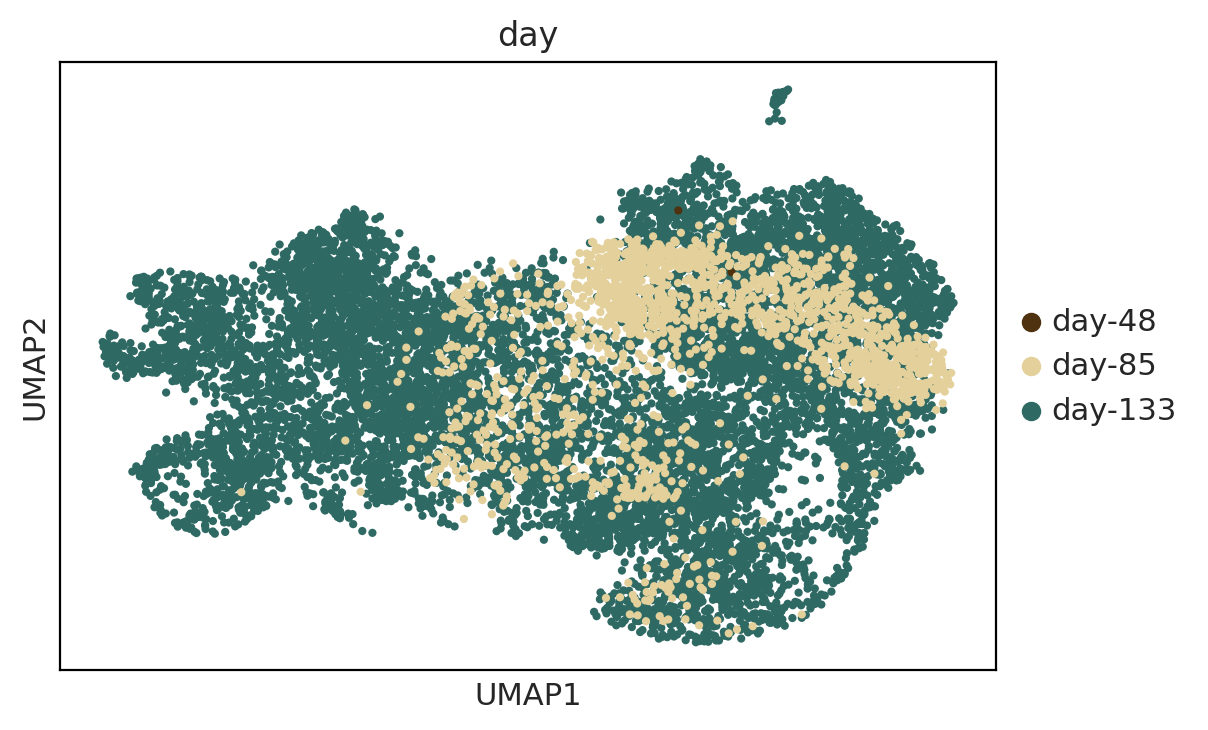

In [27]:
colors_pcw=[ '#4f3210',  '#e3d09b',  '#2e6963']

colors = colors_pcw
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
%matplotlib inline
adata.uns['day'+'_colors'] = colors
sc.pl.umap(adata, color='day', size=35, alpha=1)

In [28]:
adata_sub = obs_key_wise_subsampling(adata, var_name, 300)

/home/jovyan/scvelo/scvelo/plotting/heatmap.py:125: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[f"{col}_categorical"] = pd.Categorical(cat_col)


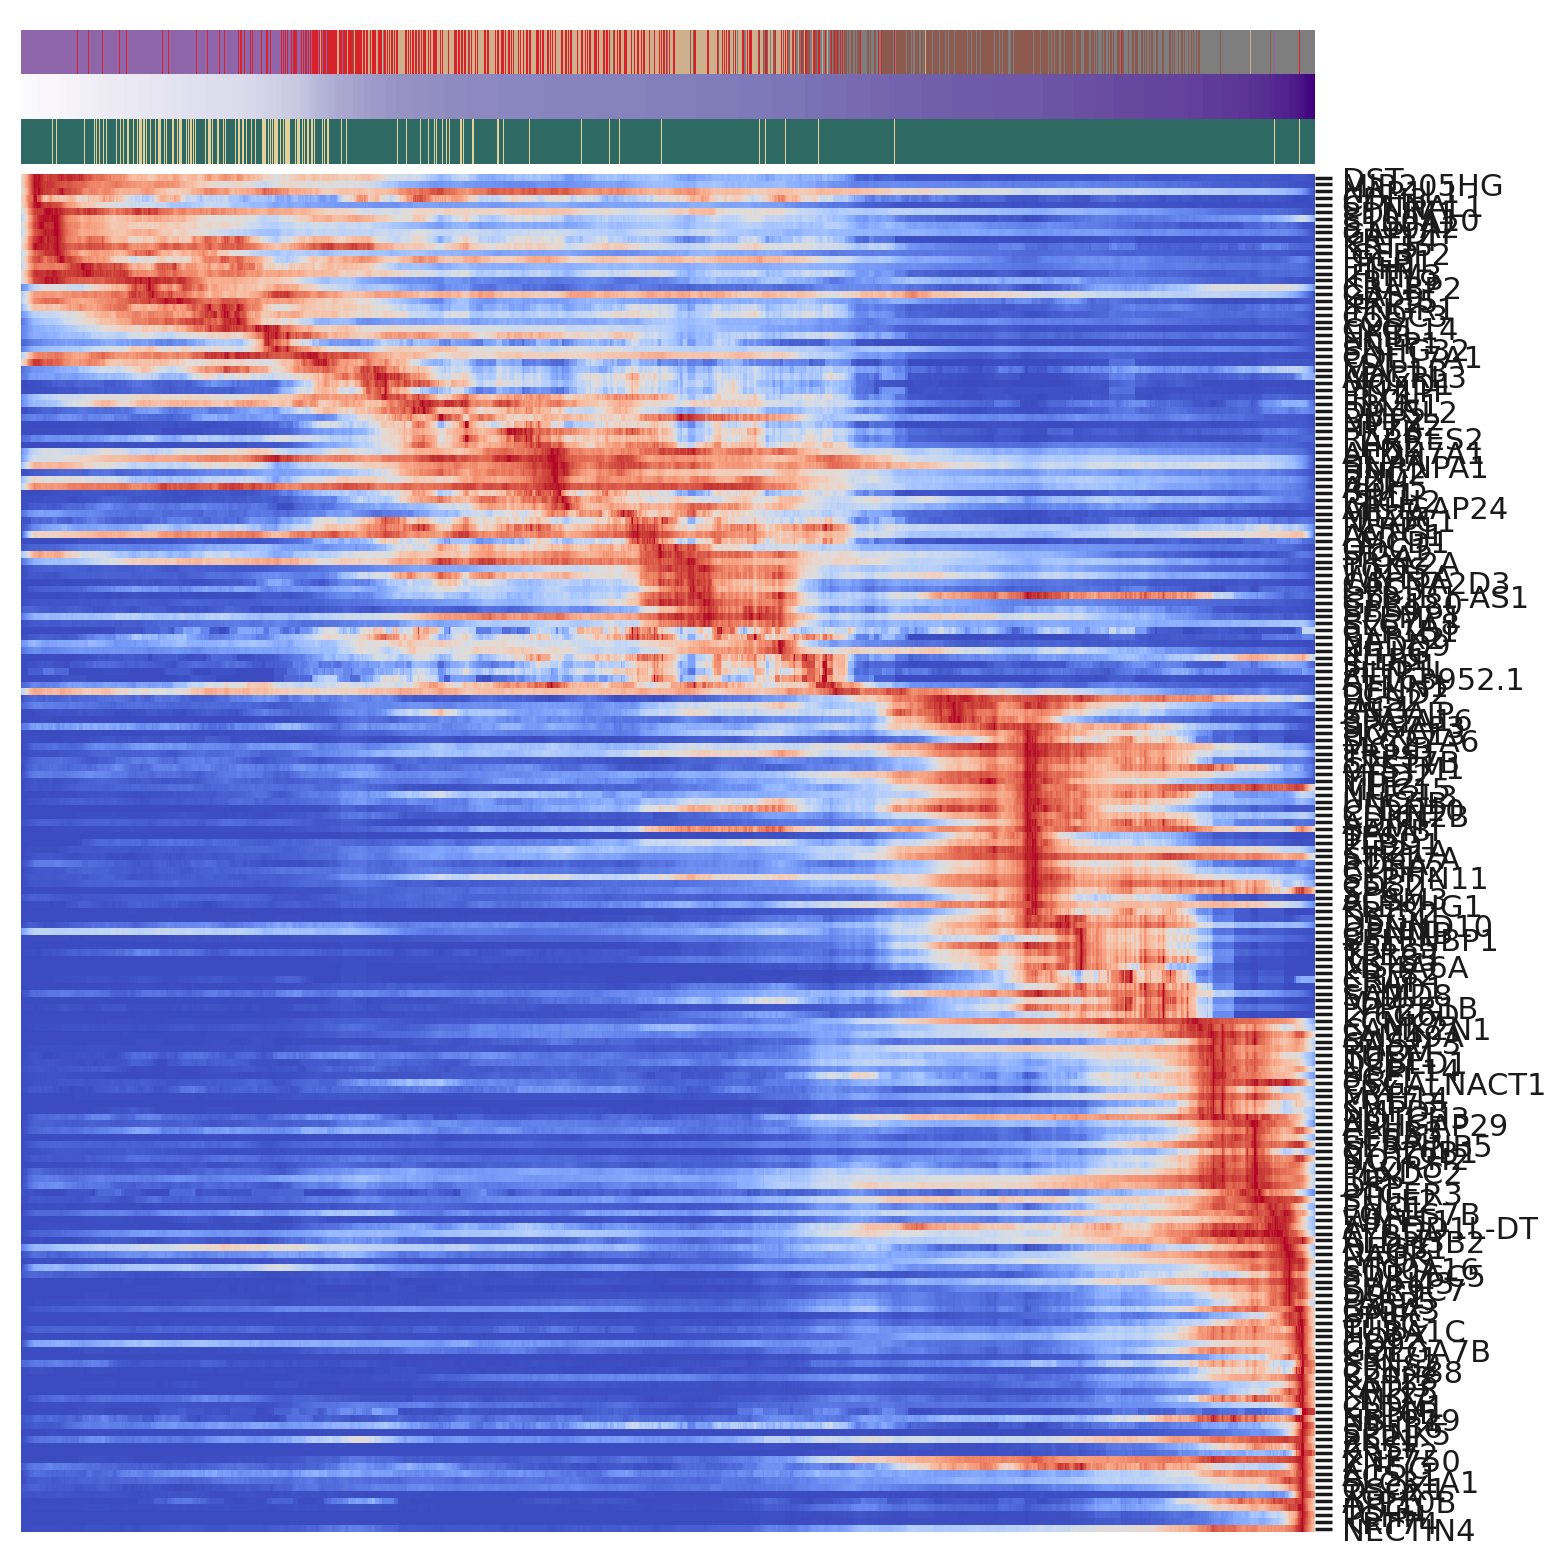

In [30]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
scv.pl.heatmap( adata_sub[adata_sub.obs[var_name].isin(['organoid_Basal POSTN+', 'organoid_Basal',  'organoid_Placode/matrix','organoid_Inner root sheath', 'organoid_Cuticle/cortex'])],
               var_names=joined_list, sortby='VelocityPalantir_matrix_pseudotime', 
               color_map='coolwarm',
               col_color=[var_name, 'VelocityPalantir_matrix_pseudotime', 'day'], palette='Purples',
               n_convolve=30, standard_scale=0, sort=True, 
               colorbar=None, col_cluster=False, row_cluster=False, yticklabels=True, figsize=(8,8))

/home/jovyan/scvelo/scvelo/plotting/heatmap.py:125: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[f"{col}_categorical"] = pd.Categorical(cat_col)


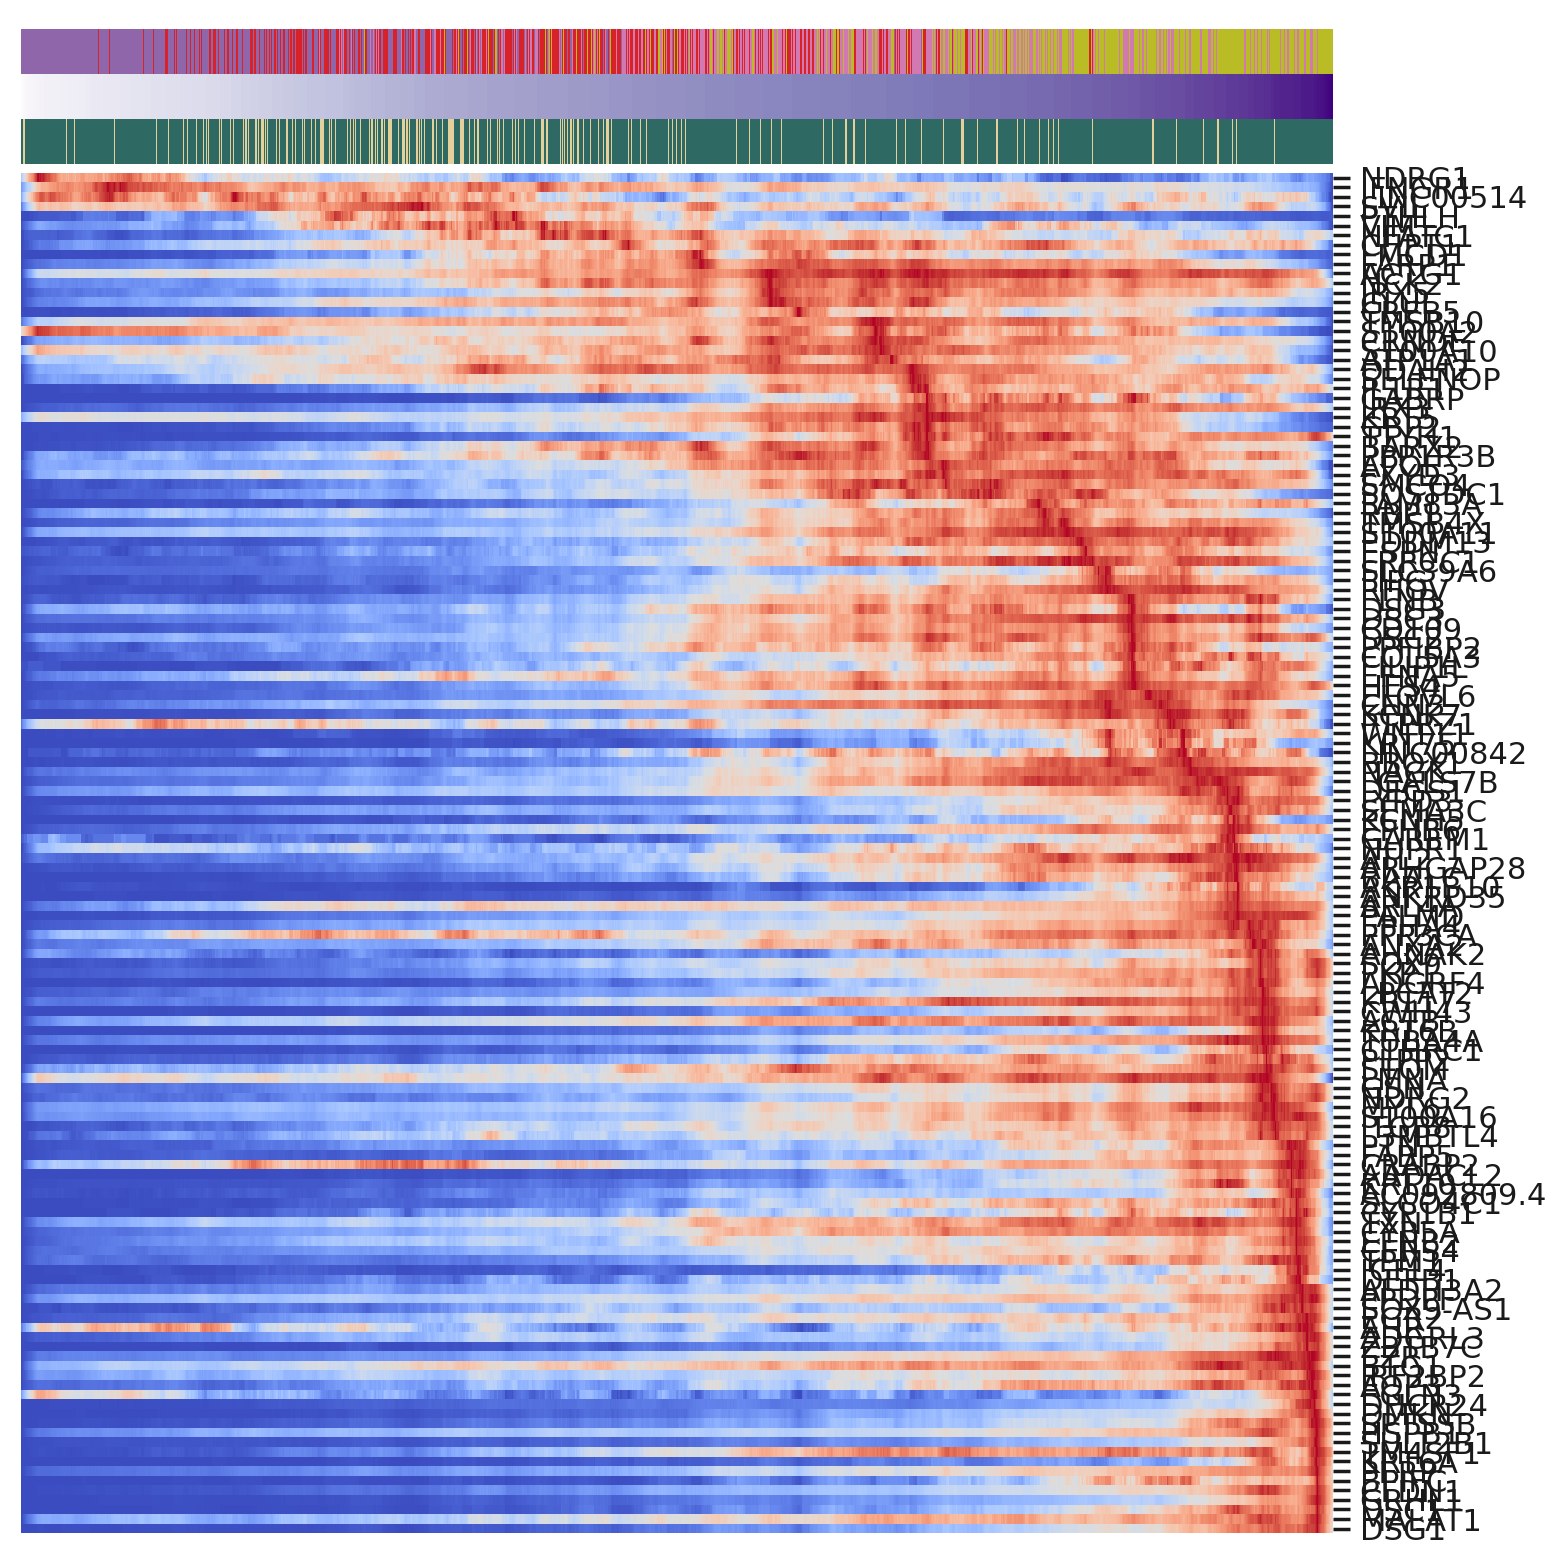

In [32]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

scv.pl.heatmap(adata_sub[adata_sub.obs[var_name].isin(['organoid_Basal POSTN+', 'organoid_Basal', 'organoid_Outer root sheath', 'organoid_Companion layer'])],
               var_names=joined_list_two, sortby='latent_time', 
               color_map='coolwarm',
               col_color=[var_name, 'latent_time', 'day'], palette='Purples',
               n_convolve=30, standard_scale=0, sort=True, 
               colorbar=None, col_cluster=False, row_cluster=False, yticklabels=True, figsize=(8,8))

In [37]:
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
pink = np.array([220/256, 220/256, 220/256, 1])
newcolors[:1, :] = pink
newcmp = ListedColormap(newcolors)


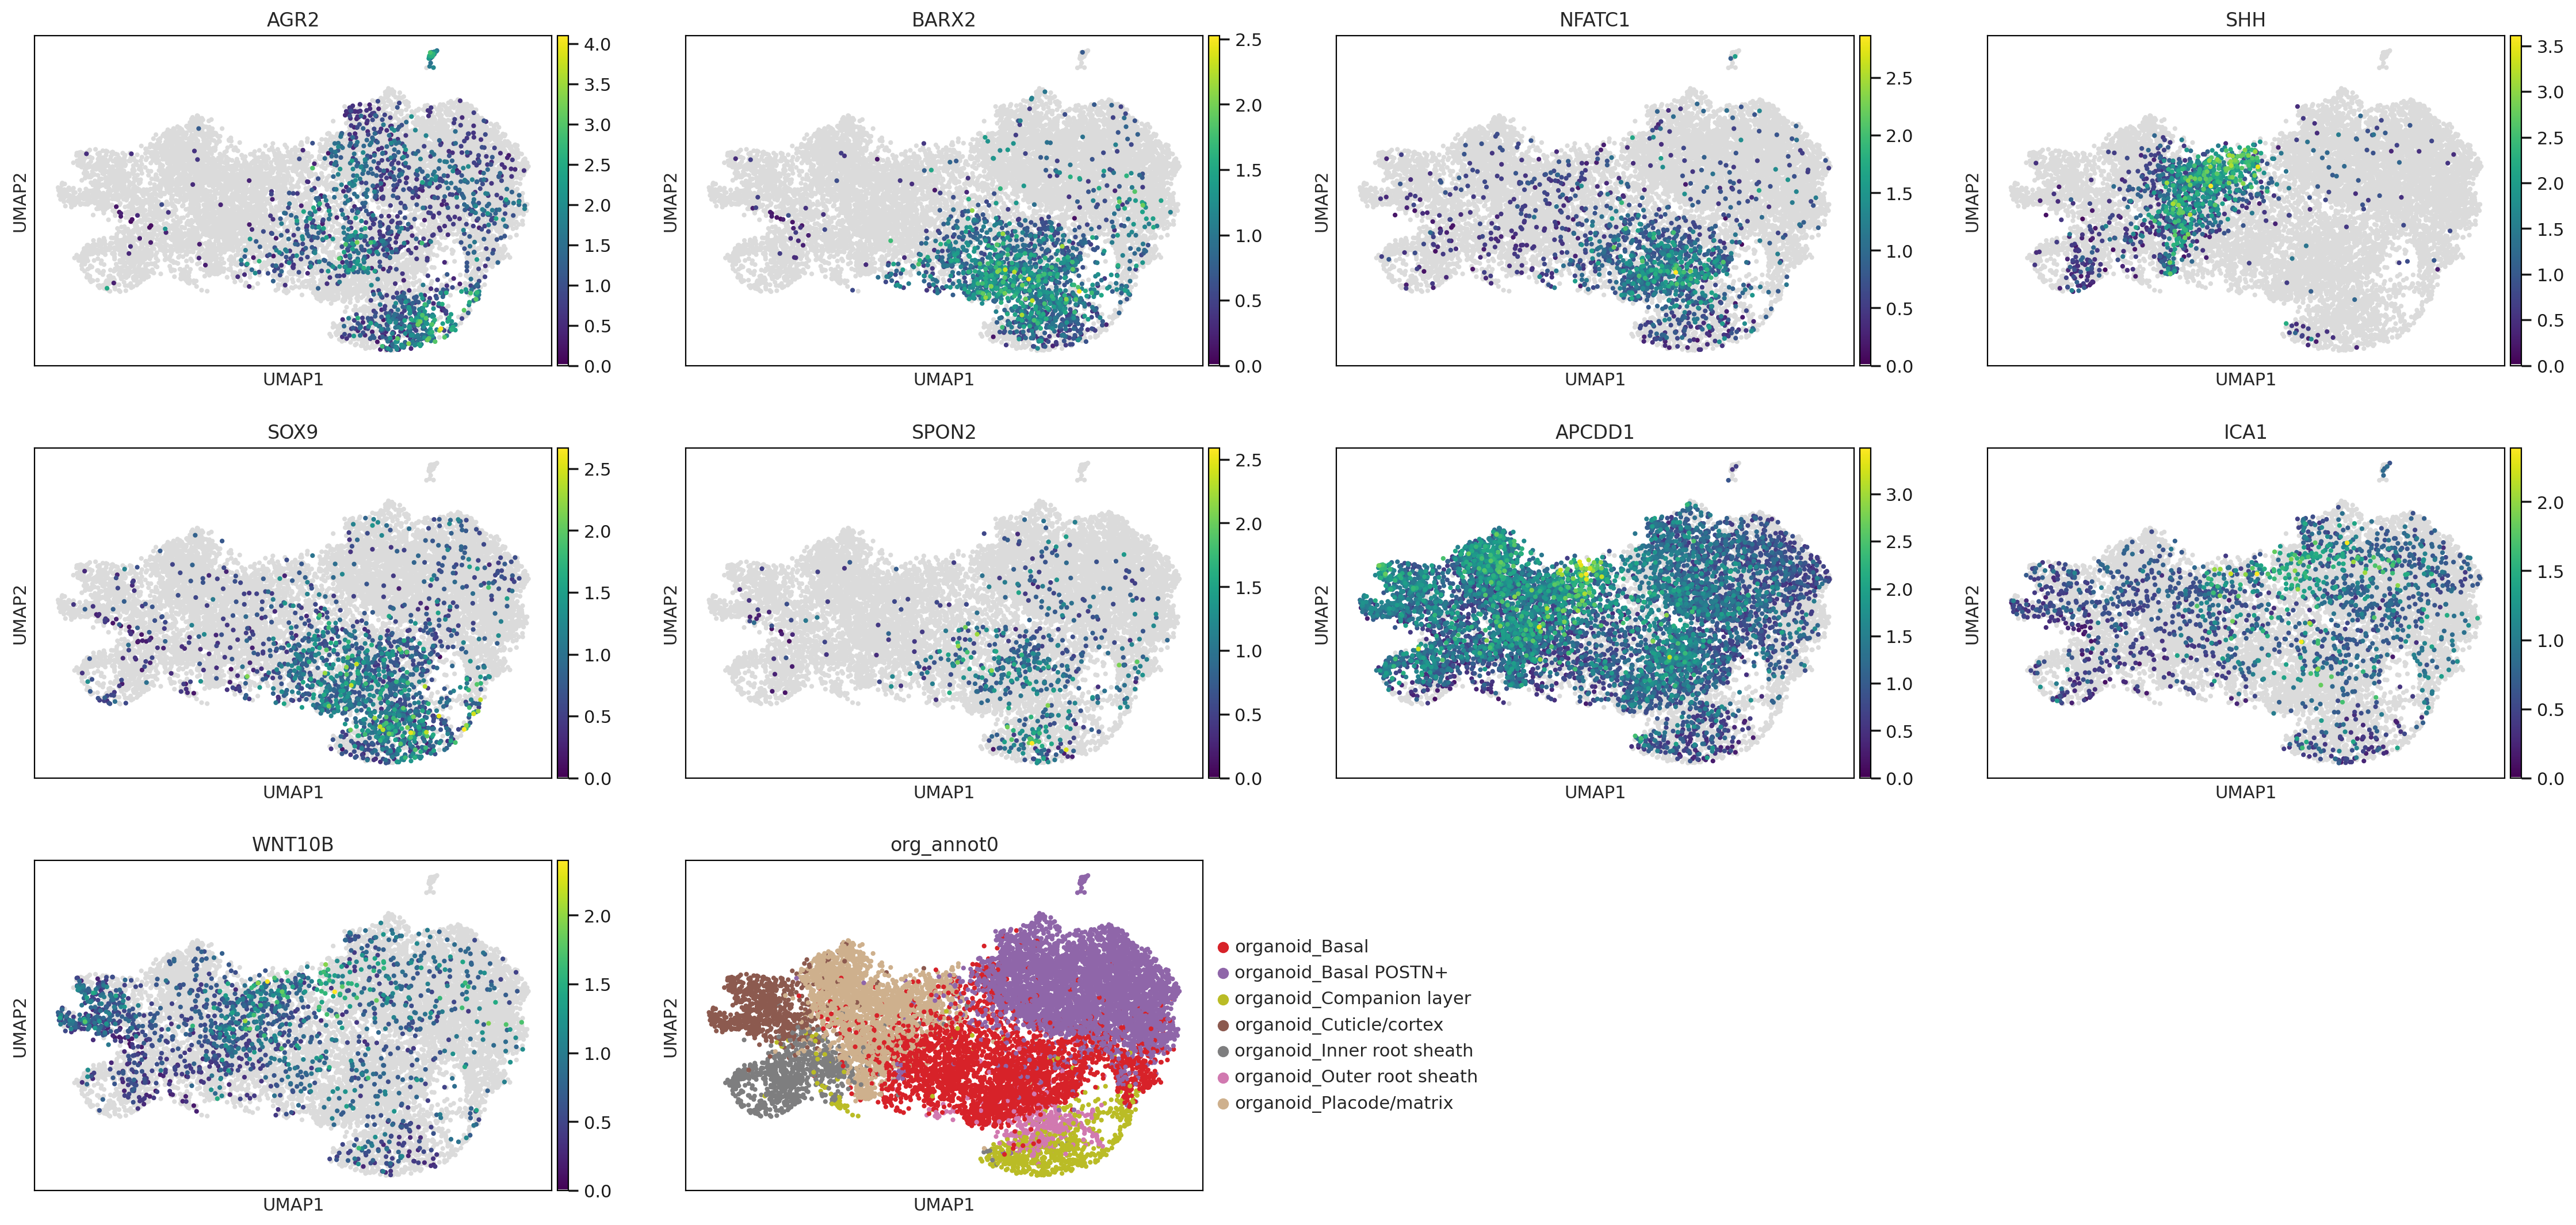

In [38]:

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sc.pl.umap(adata,size=35, alpha=1, color_map= newcmp, color=['AGR2', 'BARX2',  'NFATC1', 'SHH', 'SOX9','SPON2', 'APCDD1', 'ICA1','WNT10B', var_name], 
        )